# Моделирование по физике, вторая задача
Макаров Денис Иванович, M3301

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Функции для исполнения
## Функция подсчета "интеграла"
На самом деле, она просто берет сумму "маленьких" прямоугольников
## Загрузка данных
Конфигурация программы строится на основе JSON-файла, называемый `config.json`. Можно заглянуть в его строение, чтобы понять, как можно его задавать
## Загрузка значений потенциальной энергии в пространстве
В зависимости от того, какой тип функции для нас задан для потенциальной энергии, так и определяем его. Заметим, что если задан через пары значений в файле `potential.txt`, то аналитический из `config.json` будет игнорироваться
## Определение вероятности
Формулу взял из [Википедии](https://ru.wikipedia.org/wiki/Туннельный_эффект) из раздела `Потенциальный барьер произвольной формы`

Сама формула: $T = exp(- \sum \frac{2 \cdot \Delta x \sqrt{2m(U_i - E)}}{\hbar})$


In [43]:
hbar = 1.0545718e-34

def sum_integral(integrand, x_values):
    integrand = np.array(integrand)
    x_values = np.array(x_values)
    return np.trapezoid(integrand, x=x_values)

def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def load_potential(potential_file, analytic_expression=None, x_count=1000):
    potential_data = []
    try:
        with open(potential_file, "r") as f:
            lines = f.readlines()
            for line in lines:
                x, u = map(float, line.split())
                potential_data.append((x, u))
    except FileNotFoundError:
        print(f"Potential file {potential_file} not found. Using analytic expression.")
    if not potential_data and analytic_expression:
        x_values = np.linspace(0, h, x_count)
        potential_data = [(x, analytic_expression(x)) for x in x_values]
    return np.array(potential_data)

def tunneling_probability(m, E, potential):
    x, U = potential[:, 0], potential[:, 1]

    forbidden_region = U > E
    if not np.any(forbidden_region):
        return 1.0
    
    x_forbidden = x[forbidden_region]
    U_forbidden = U[forbidden_region]
    integrand = np.sqrt(2 * m * (U_forbidden - E)) / hbar
    integral = sum_integral(integrand, x_forbidden)
    return np.exp(-2 * integral)

In [44]:
config = load_config("config.json")
m = config["mass"]
E = config["energy"]
h = config["barrier_range"]
x_count = config["x_count"]

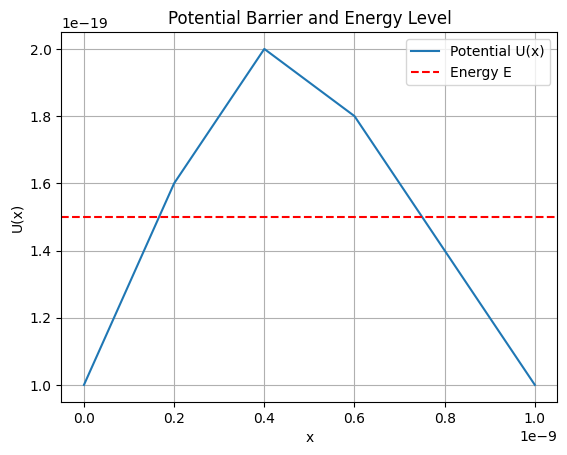

Tunneling probability: 1.581583e-01


In [45]:
analytic_expr = eval("lambda x: " + config["analytic_potential"])

potential = load_potential("potential.txt", analytic_expression=analytic_expr, x_count=x_count)

probability = tunneling_probability(m, E, potential)

plt.plot(potential[:, 0], potential[:, 1], label="Potential U(x)")
plt.axhline(E, color="red", linestyle="--", label="Energy E")
plt.xlabel("x")
plt.ylabel("U(x)")
plt.title("Potential Barrier and Energy Level")
plt.legend()
plt.grid()
plt.show()

print(f"Tunneling probability: {probability:.6e}")